In [1]:
import torch
from vggt.models.vggt import VGGT
from vggt.utils.load_fn import load_and_preprocess_images
from vggt.utils.pose_enc import pose_encoding_to_extri_intri
from vggt.utils.geometry import unproject_depth_map_to_point_map

import open3d as o3d
import numpy as np
import os
import glob
from matplotlib import pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# bfloat16 is supported on Ampere GPUs (Compute Capability 8.0+) 
dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16

In [3]:
model = VGGT()
_URL = "./model.pt"
model.load_state_dict(torch.load(_URL))
model.eval()
model = model.to(device)

/tmp/ipykernel_101152/2406001790.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(_URL))


In [4]:
path = "/root/autodl-tmp/facescape/mv_image/1_16view"

image_names = sorted(glob.glob(os.path.join(path, "*.jpg")))

In [5]:
import cv2

new_image_names = []
for image_name in image_names:
    image = cv2.imread(image_name)
    if image.shape[0] > image.shape[1]:
        new_image_names.append(image_name)
image_names = new_image_names

In [6]:
# random sample 16 images
import random
image_names = random.sample(image_names, 16)

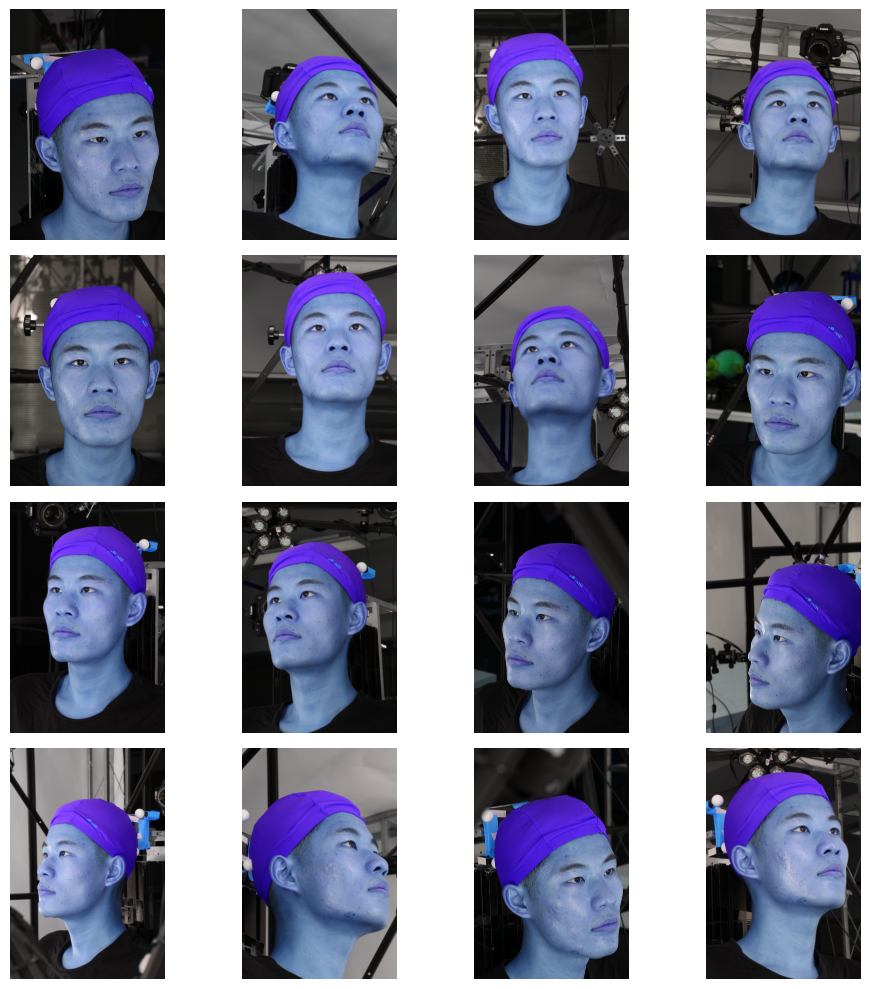

In [6]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    image = cv2.imread(image_names[i])
    ax.imshow(image)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [7]:
images = load_and_preprocess_images(image_names).to(device)

with torch.no_grad():
    with torch.cuda.amp.autocast(dtype=dtype):
        images = images[None]  # add batch dimension
        aggregated_tokens_list, ps_idx = model.aggregator(images)
                
    # Predict Cameras
    pose_enc = model.camera_head(aggregated_tokens_list)[-1]
    # Extrinsic and intrinsic matrices, following OpenCV convention (camera from world)
    extrinsic, intrinsic = pose_encoding_to_extri_intri(pose_enc, images.shape[-2:])

    # Predict Depth Maps
    depth_map, depth_conf = model.depth_head(aggregated_tokens_list, images, ps_idx)

    # Predict Point Maps
    point_map, point_conf = model.point_head(aggregated_tokens_list, images, ps_idx)
        
    # Construct 3D Points from Depth Maps and Cameras
    # which usually leads to more accurate 3D points than point map branch
    point_map_by_unprojection = unproject_depth_map_to_point_map(depth_map.squeeze(0), 
                                                                extrinsic.squeeze(0), 
                                                                intrinsic.squeeze(0))

/tmp/ipykernel_77346/1166783532.py:4: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=dtype):


In [8]:
point_all = point_map_by_unprojection.reshape(-1, 3)
color_all = images[0].permute(0, 2, 3, 1).reshape(-1, 3).detach().cpu().numpy()
conf_all = depth_conf[0].reshape(-1,).detach().cpu().numpy()
threshold = np.median(conf_all)
conf_mask = conf_all > threshold
point_all = point_all[conf_mask]
color_all = color_all[conf_mask]

In [7]:
use_scan_points = True
if use_scan_points:
    scan_path = "/root/autodl-tmp/facescape/scan/1_neutral.ply"
    scan_mesh = o3d.io.read_triangle_mesh(scan_path)
    scan_points = np.asarray(scan_mesh.vertices)
    point_all = scan_points
    color_all = np.ones_like(scan_points) * 0.6

In [8]:
# 此时point数量太多了，没法学，sample出30000个点
import random
sample_indices = random.sample(range(point_all.shape[0]), 30000)

points = point_all[sample_indices]
colors = color_all[sample_indices]

In [23]:
# load target mesh
target_mesh = o3d.io.read_triangle_mesh("/root/autodl-tmp/facescape/mesh/1_neutral_align.ply")
faces = np.asarray(target_mesh.triangles)
vertices = np.asarray(target_mesh.vertices)

In [90]:
from pytorch3d.transforms import matrix_to_rotation_6d, rotation_6d_to_matrix

point_prob = torch.nn.Parameter(torch.randn((points.shape[0], vertices.shape[0]),device="cuda"))
scale = torch.nn.Parameter(torch.ones(1, device="cuda"))
I = torch.eye(3, device="cuda").unsqueeze(0)
I_6d = matrix_to_rotation_6d(I)
R = torch.nn.Parameter(I_6d.clone().cuda())
t = torch.nn.Parameter(torch.zeros(1, 3, device="cuda"))

In [12]:
def umeyama(P, Q):
    assert P.shape == Q.shape
    n, dim = P.shape

    centeredP = P - P.mean(axis=0)
    centeredQ = Q - Q.mean(axis=0)

    C = np.dot(np.transpose(centeredP), centeredQ) / n

    V, S, W = np.linalg.svd(C)
    d = (np.linalg.det(V) * np.linalg.det(W)) < 0.0

    if d:
        S[-1] = -S[-1]
        V[:, -1] = -V[:, -1]

    R = np.dot(V, W)

    varP = np.var(P, axis=0).sum()
    c = 1/varP * np.sum(S) # scale factor

    t = Q.mean(axis=0) - P.mean(axis=0).dot(c*R)

    return c, R, t

def shape_loss(source_vertices, target_vertices):
    # per-vertex loss
    assert source_vertices.shape[0] == target_vertices.shape[0]
    assert source_vertices.shape[1] == target_vertices.shape[1]
    
    # first estimate the scale, rotation and translation
    c, R, t = umeyama(source_vertices.detach().cpu().numpy(), target_vertices.detach().cpu().numpy())
    R = torch.from_numpy(R).to(source_vertices.device)
    t = torch.from_numpy(t).to(source_vertices.device)
    # apply the transformation
    source_vertices = c * source_vertices @ R + t
    loss = torch.mean(torch.sum((source_vertices - target_vertices) ** 2, dim=1))
    return loss

def vertice_loss(source_vertices, target_vertices):
    loss = torch.mean(torch.sum((source_vertices - target_vertices) ** 2, dim=1))
    return loss

In [123]:
# prepare optimizer
optimizer = torch.optim.Adam([point_prob], lr=1)
optimizer_others = torch.optim.Adam([scale, R, t], lr=1e-1)

In [92]:
class SummaryWriter():
    def __init__(self) -> None:
        self.losses = {}
    
    def add_scalar(self,name,value):
        if name not in self.losses:
            self.losses[name] = []
        self.losses[name].append(value)
    
    def plot(self, start_step=0):
        for key in self.losses.keys():
            plt.plot(self.losses[key][start_step:],label=key)
        plt.legend()
        plt.show()
summary_writer = SummaryWriter()

In [15]:
# prepare hyperparameters
epochs = 1000

In [24]:
# points = torch.from_numpy(points).to("cuda") # 30000, 3
vertices = torch.from_numpy(vertices).to("cuda") # num_vertices, 3

In [171]:
# adust optimizer learning rate with 0.1
for param_group in optimizer.param_groups:
    param_group['lr'] = 0.5 * param_group['lr']

In [17]:
def sample_mesh(points, point_prob_softmax):
    res_indices = np.zeros(point_prob_softmax.shape[1])
    N = points.detach().cpu().numpy().shape[0]
    ps = point_prob_softmax.detach().cpu().numpy()
    for i in range(point_prob_softmax.shape[1]):
        res_indices[i] = np.random.choice(N,p = ps[:,i])
    res_indices = torch.from_numpy(res_indices).long().to(points.device)
    res_points = points[res_indices]
    return res_points

In [62]:
from tqdm import trange
import random

for epoch in (tbar:=trange(epochs)):
    # compute ours mesh with expectation
    point_prob_softmax = torch.softmax(point_prob, dim=0) # 30000, num_vertices
    points_mesh = point_prob_softmax.T @ points.float() # num_vertices, 3
    
    # apply transform
    R_matrix = rotation_6d_to_matrix(R)
    # points_mesh = torch.nn.functional.sigmoid(scale) * points_mesh @ R_matrix + t
    points_mesh = points_mesh @ R_matrix + t
    points_mesh = points_mesh[0]
    
    # compute loss
    loss_shape = vertice_loss(points_mesh, vertices.float())
    
    
    
    loss =  loss_shape
    
    
    # optimize
    optimizer.zero_grad()
    optimizer_others.zero_grad()
    loss.backward()
    optimizer.step()
    optimizer_others.step()
    
    # print loss
    tbar.set_description(f"loss: {loss.item():.4g}")
    summary_writer.add_scalar("shape loss", loss_shape.item())

loss: 1.817e-08:   2%|▏         | 16/1000 [00:01<01:38, 10.02it/s]


KeyboardInterrupt: 

In [124]:
for epoch in (tbar:=trange(epochs)):
    # apply transform
    R_matrix = rotation_6d_to_matrix(R)
    points_mesh = points.float() @ R_matrix + t
    points_mesh = points_mesh[0] # 30000, 3
    
    distance_matrix = torch.cdist(points_mesh, vertices.float(), p=2) # 30000, num_vertices
    point_prob_softmax = torch.softmax(point_prob, dim=0) # 30000, num_vertices
    
    
    # compute loss
    loss_shape = distance_matrix * point_prob_softmax
    loss_shape = torch.sum(loss_shape)
    
    loss =  loss_shape
    
    
    # optimize
    optimizer.zero_grad()
    # optimizer_others.zero_grad()
    loss.backward()
    optimizer.step()
    # optimizer_others.step()
    
    # print loss
    tbar.set_description(f"loss: {loss.item():.4g}")
    summary_writer.add_scalar("shape loss", loss_shape.item())

loss: 295.9:  21%|██        | 208/1000 [00:29<01:52,  7.06it/s]


KeyboardInterrupt: 

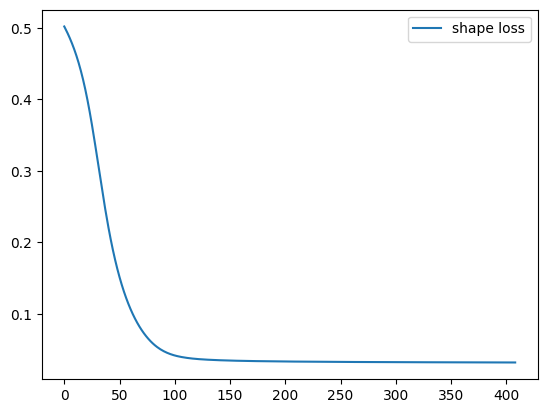

In [98]:
summary_writer.plot(20)

In [125]:
point_prob_softmax_copy = point_prob_softmax.detach().clone().cuda()
total_dist = 0

dist_matrix = torch.cdist(points, vertices, p=2) # 30000, num_vertices

for i in range(point_prob_softmax_copy.shape[1]):
    max_ind = torch.argmin(dist_matrix[:, i])
    point_prob_softmax_copy[:, i ] = 0
    point_prob_softmax_copy[max_ind, i] = 1
    
    total_dist += dist_matrix[max_ind, i]
print("total_dist", total_dist.item())

total_dist 61.34025740381453


In [133]:
torch.sum(distance_matrix * point_prob_softmax_copy)

tensor(60.8321, device='cuda:0', grad_fn=<SumBackward0>)

In [116]:
# save result mesh
R_matrix = rotation_6d_to_matrix(R)
points_mesh = points.float() @ R_matrix + t
points_mesh = points_mesh[0] # 30000, 3
points_mesh = point_prob_softmax_copy.T @ points_mesh

results_mesh = o3d.geometry.TriangleMesh()
results_mesh.vertices = o3d.utility.Vector3dVector(points_mesh.detach().cpu().numpy())
results_mesh.triangles = o3d.utility.Vector3iVector(faces)

# write mesh
results_mesh.compute_vertex_normals()
results_mesh.paint_uniform_color([0.7, 0.7, 0.7])

o3d.io.write_triangle_mesh("/root/autodl-tmp/facescape/result/1_neutral.ply", results_mesh)

True

In [105]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points.detach().cpu().numpy())

o3d.io.write_point_cloud("/root/autodl-tmp/facescape/result/sample_points.ply", pcd)

pcd.points = o3d.utility.Vector3dVector(points_mesh.detach().cpu().numpy())
o3d.io.write_point_cloud("/root/autodl-tmp/facescape/result/points_mesh.ply", pcd)

True

In [95]:
template_ind = 5096

from matplotlib import cm
from matplotlib import pyplot as plt
def apply_color_map(data,cmap = 'viridis', vmin=None, vmax=None):
    data = np.array(data)
    if vmin is None:
        v_min = np.min(data)
    if vmax is None:
        v_max = np.max(data)
    return getattr(cm,cmap)(plt.Normalize(vmin,vmax)(data))[...,:3]

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points.detach().cpu().numpy())

color = point_prob_softmax[:, template_ind].detach().cpu().numpy()
color = apply_color_map(color)
pcd.colors = o3d.utility.Vector3dVector(color)

o3d.io.write_point_cloud("/root/autodl-tmp/facescape/result/sample_points.ply", pcd)

True

In [110]:
np.sort(point_prob_softmax[:, template_ind].detach().cpu().numpy())

array([1.0330907e-12, 3.0402183e-12, 3.4599272e-12, ..., 8.8497960e-05,
       4.6006480e-04, 9.9937159e-01], dtype=float32)

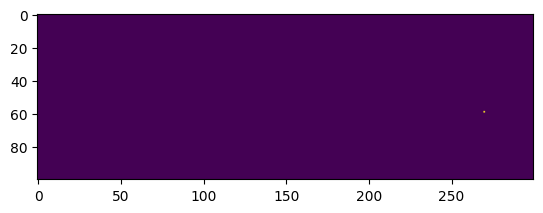

In [101]:
plt.imshow(color.reshape(100, 300, 3))